In [1]:
import sys
sys.path.append('../python_packages_static/')
import pandas as pd
import pyemu
import os, glob
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np

# After Running prior Monte Carlo, we can postprocess to perform rejection sampling and prepare for next run

### NOTE: Make sure  `run_ensemble` is set appropriately - If `run_ensemble` is set to `True`, local runs are performed. If `run_ensemble` set to `False`results from the journal article are used. 

In [2]:
run_ensemble=False

In [3]:
if run_ensemble==True:
    wkdir = '../run_data/' #data in which PEST++ runs take place and results live
else:
    wkdir = '../output/parallel/'
pstroot='prior_mc'

In [4]:
wkdir

'../output/parallel/'

### read in the ensemble of observations

In [5]:
ens = pd.read_csv(os.path.join(wkdir,'{}.0.obs.csv'.format(pstroot)), index_col=0)

### read in the phi values for the ensemble

In [6]:
phi = pd.read_csv(os.path.join(wkdir,'{}.phi.actual.csv'.format(pstroot)))

### read in the parameter ensemble

In [7]:
parens = pd.read_csv(os.path.join(wkdir, '{}.0.par.csv'.format(pstroot)), index_col=0)

C:\ProgramData\Anaconda3\envs\neversink\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
parens.head()

,wel__:0_usecol:3_idx0:0_idx1:225_idx2:185,wel__:0_usecol:3_idx0:0_idx1:556_idx2:459,wel__:0_usecol:3_idx0:3_idx1:260_idx2:180,wel__:0_usecol:3_idx0:2_idx1:249_idx2:181,wel__:0_usecol:3_idx0:1_idx1:249_idx2:536,wel__:0_usecol:3_idx0:1_idx1:248_idx2:536,wel__:0_usecol:3_idx0:0_idx1:299_idx2:255,wel__:0_usecol:3_idx0:3_idx1:236_idx2:185,wel__:0_usecol:3_idx0:0_idx1:248_idx2:181,wel__:0_usecol:3_idx0:3_idx1:237_idx2:198,...,sfrk_200065969,sfrk_200250814,sfrk_200027277,sfrk_700040140,sfrk_200308941,sfrk_700050332,sfrk_200173393,sfrk_700021654,sfrk_700020798,sfrk_700050017
real_name,,,,,,,,,,,,,,,,,,,,,
0,1.131940,1.050270,0.925092,1.004850,1.190890,1.030110,1.093650,0.906845,1.036420,1.002920,...,0.817229,1.179020,1.392090,1.075630,0.640235,0.460214,2.180500,0.302831,6.613040,5.310940
1,0.964115,0.998230,0.946580,0.888467,1.050260,0.904969,0.998112,1.065210,1.042690,0.974670,...,0.340927,0.618212,9.495810,0.202832,0.817942,4.887940,1.919850,0.438854,3.688670,1.978360
2,0.935386,0.966759,1.082880,0.987447,0.931025,1.121370,0.962847,0.846860,1.062520,0.997255,...,0.306953,1.654090,2.237110,0.727079,0.167653,0.755582,2.337580,3.403400,0.167582,0.565267
3,1.011890,1.144000,1.051760,0.892756,1.085580,0.955911,1.087550,1.033170,1.200000,0.862943,...,0.543204,4.526880,0.527462,0.991547,2.449530,1.480130,0.318217,1.510950,0.379445,1.186500
4,0.978990,0.887770,0.957323,1.002880,0.822460,0.953946,1.013440,1.009380,0.832213,0.945799,...,0.100000,1.743240,0.761709,0.110102,5.270970,1.241450,1.207280,1.074280,8.162120,1.809600


### look at a histogram of Phi and make a subjective call for where to truncate for rejection sampling
If `run_ensemble=True` and using a smaller number of realizatios than used in the report (500) this may not be a normal distribution

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

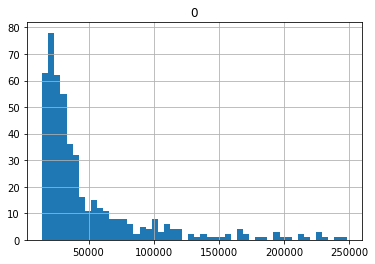

In [9]:
phi.T.dropna().iloc[6:].hist(bins=50)

In [10]:
phi

,iteration,total_runs,mean,standard_deviation,min,max,0,1,2,3,...,490,491,492,493,494,495,496,497,498,base
0,0,500,48818,43484.3,14400.3,248031,35227.9,79999.3,49708.8,22615.7,...,63279.2,35206.9,130344,41756.9,18466.5,29820.9,38476,21880.1,43803,29487.5


In [11]:
# adjust threshold based on histogram
phi_threshold_for_keeping = 35000 # prior_mc phi cutoff == 35000 used in joural article
allphi=phi.T.dropna().iloc[6:].copy()
allphi.columns=['phi']
keepreals = allphi.loc[allphi.phi<phi_threshold_for_keeping].index
keepreals

Index(['3', '5', '6', '10', '13', '14', '15', '17', '18', '24',
       ...
       '476', '479', '480', '483', '484', '489', '494', '495', '497', 'base'],
      dtype='object', length=278)

### now trim phi to only the realizations to keep

array([[<AxesSubplot:title={'center':'phi'}>]], dtype=object)

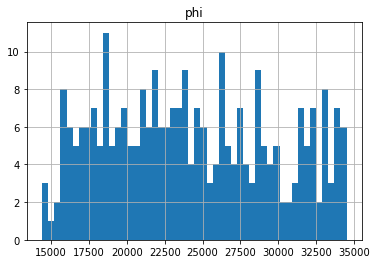

In [12]:
allphi.loc[keepreals].hist(bins=50)

In [13]:
# truncate the ensemble to only keepreals (based on phi)
ens = ens.loc[keepreals]
# set percent_discrepancy to absolute value because we don't care about the sign
ens.perc_disc = ens.perc_disc.apply(lambda x: np.abs(x))

In [14]:
# further truncate to eliminate bad mass balance runs 
print(len(ens))
ens = ens.loc[ens.perc_disc<0.01]
ens

278


,q_1436500,q_1366650,h_414525074360601,h_o10577,h_o10942,h_o11068,h_o5124,h_o6269,h_o7421,h_o8073,...,land_surf_obs_500_400,land_surf_obs_500_450,land_surf_obs_500_500,land_surf_obs_550_400,land_surf_obs_550_450,land_surf_obs_550_500,land_surf_obs_600_350,land_surf_obs_600_400,land_surf_obs_600_450,land_surf_obs_650_450
3,99832,147810,358.893,207.743,154.428,123.889,348.937,502.173,159.576,208.724,...,411.683,217.326,176.817,334.927,170.078,335.654,431.671,277.193,154.054,250.318
5,100260,147380,358.823,207.175,155.679,125.904,351.762,502.758,155.842,205.564,...,410.311,217.556,179.145,343.539,173.156,334.824,427.535,276.491,155.270,246.737
6,97320,135800,358.798,209.716,154.235,126.367,353.162,500.048,164.863,212.836,...,410.015,217.640,181.621,343.279,171.853,337.078,428.093,278.671,153.987,247.761
10,98650,143960,358.779,217.800,155.181,127.638,355.118,507.895,172.265,218.943,...,416.285,218.818,181.612,346.077,172.884,338.361,439.092,279.159,154.054,248.190
13,99917,144220,359.286,205.798,155.580,123.422,351.103,506.762,161.850,210.048,...,408.472,217.068,182.713,338.494,173.576,336.654,428.684,276.714,154.627,246.671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,94431,132860,358.420,209.999,155.066,129.448,350.906,506.655,166.114,215.338,...,411.526,218.107,179.754,344.333,172.505,338.812,441.000,279.042,153.894,247.249
494,100220,143220,359.074,215.732,154.843,125.696,353.229,493.023,163.214,211.685,...,409.277,217.264,181.241,335.929,172.051,335.709,426.751,280.883,154.552,248.820
495,102270,151760,358.974,208.994,154.138,125.559,359.098,505.772,166.525,213.955,...,409.952,218.283,184.706,348.093,174.451,336.660,436.548,277.951,154.619,246.901
497,96207,141890,358.946,209.855,155.245,125.522,351.405,505.270,167.556,214.786,...,410.607,217.632,187.219,347.810,174.438,340.389,442.660,279.766,154.403,248.638


In [15]:
# reset keepreals based now both on phi and mass balance
keepreals = ens.index.values

array([[<AxesSubplot:title={'center':'phi'}>]], dtype=object)

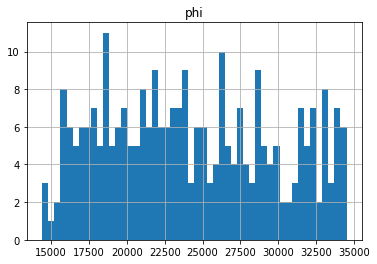

In [16]:
# look at phi again
allphi.loc[keepreals].hist(bins=50)

In [17]:
allphi.loc[keepreals]

,phi
3,22615.7
5,20429.1
6,17087.8
10,27746.7
13,19421.4
...,...
489,17774.7
494,18466.5
495,29820.9
497,21880.1


In [18]:
pst = pyemu.Pst(os.path.join(wkdir,'{}.pst'.format(pstroot)))

In [19]:
obs = pst.observation_data

In [20]:
obs

,obsnme,obsval,weight,obgnme,extra
obsnme,,,,,
q_1436500,q_1436500,116217.231560,0.001405,flux,NaN
q_1366650,q_1366650,124046.273310,0.003954,flux,NaN
h_414525074360601,h_414525074360601,357.182016,0.090062,head,NaN
h_o10577,h_o10577,203.903379,0.090062,head,NaN
h_o10942,h_o10942,150.660417,0.090062,head,NaN
...,...,...,...,...,...
land_surf_obs_550_500,land_surf_obs_550_500,365.440000,0.606785,land_surface,NaN
land_surf_obs_600_350,land_surf_obs_600_350,443.410000,0.606785,land_surface,NaN
land_surf_obs_600_400,land_surf_obs_600_400,300.950000,0.606785,land_surface,NaN


### can plot out histograms for all observations into a large, multipage PDF file

In [21]:
plot_pdf=False

In [22]:
if plot_pdf==True:
    with PdfPages('../figures/{}}_obs_hist_plots.pdf'.format(pstroot)) as outpdf:
        for cob in obs.obsnme.values:
            plt.figure()
            ens[cob].hist(bins=50)
            obsval = obs.loc[cob].obsval
            plt.axvline(obsval, color='orange')
            plt.title(cob)
            outpdf.savefig()
            plt.close('all')